# Fasion-Mnistの読み込み

In [1]:
import pandas as pd
train_df = pd.read_csv('./archive/fashion-mnist_train.csv',sep=',')
test_df = pd.read_csv('./archive/fashion-mnist_test.csv', sep = ',')

In [2]:
import numpy as np
train_data = np.array(train_df, dtype = 'float32')

In [3]:
test_data = np.array(test_df, dtype='float32')
#test_data = np.array(test_df, dtype='uint8')

In [4]:
x_train = train_data[:,1:]/255

t_train = train_data[:,0]
t_train = np.array(t_train, dtype = 'uint8')

x_test= test_data[:,1:]/255

t_test=test_data[:,0]
t_test = np.array(t_test, dtype = 'uint8')

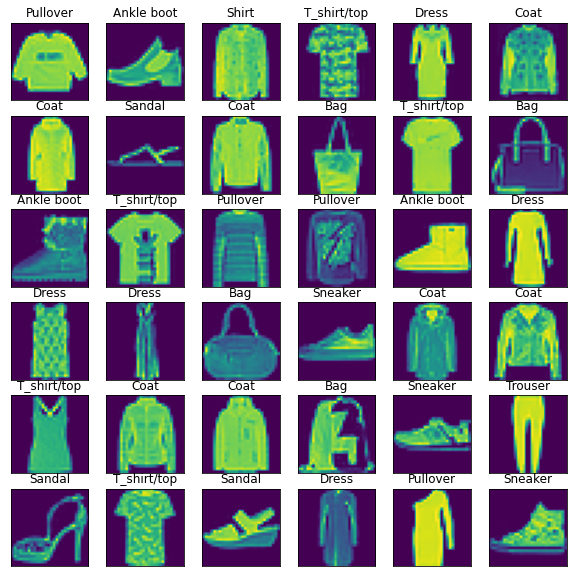

In [5]:
import matplotlib.pyplot as plt
class_names = ['T_shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
plt.figure(figsize=(10, 10))
for i in range(36):
    plt.subplot(6, 6, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i].reshape((28,28)))
    label_index = int(t_train[i])
    plt.title(class_names[label_index])
plt.show()

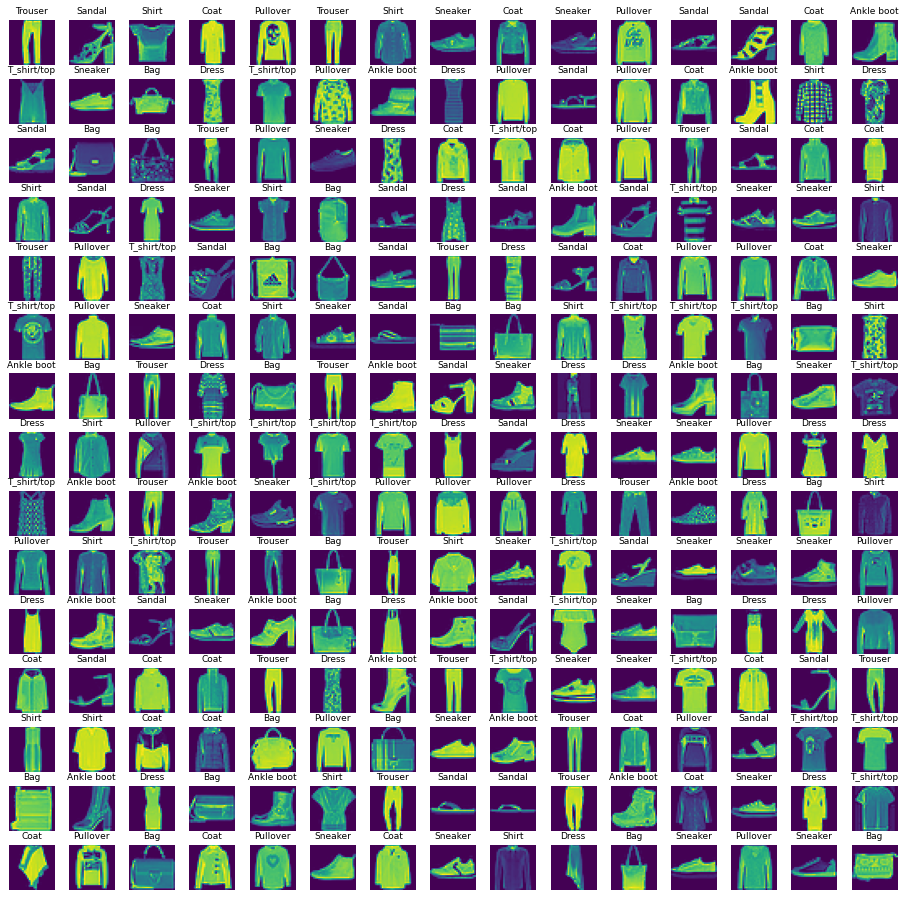

In [6]:
W_grid = 15
L_grid = 15

fig, axes = plt.subplots(L_grid, W_grid, figsize = (16,16))
axes = axes.ravel() # flaten the 15 x 15 matrix into 225 array
n_train = len(train_data) # get the length of the train dataset

# Select a random number from 0 to n_train
for i in np.arange(0, W_grid * L_grid): # create evenly spaces variables 

    # Select a random number
    index = np.random.randint(0, n_train)
    # read and display an image with the selected index    
    axes[i].imshow( train_data[index,1:].reshape((28,28)) )
    labelindex = int(train_data[index,0])
    axes[i].set_title(class_names[labelindex], fontsize = 9)
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.3)

In [7]:
print(np.shape(x_train))

(60000, 784)


In [8]:
image_rows = 28
image_cols = 28
batch_size = 4096
image_shape = (1,image_rows,image_cols) 

In [9]:
x_train = x_train.reshape(x_train.shape[0],*image_shape)
x_test = x_test.reshape(x_test.shape[0],*image_shape)
#x_validate = x_validate.reshape(x_validate.shape[0],*image_shape)

# CNNの実装


## 引数

- input_dim ―― 入力データの (チャンネル, 高さ, 幅) の次元
- conv_param ―― 畳み込み層のハイパーパラメータ(ディクショナリ)。ディクショナリのキーは下記のとおり
  -   filter_num ―― フィルターの数 

  -  filter_size ―― フィルターのサイズ

  -  stride ―― ストライド 

  -  pad ―― パディング 
- hidden_size ―― 隠れ層(全結合)のニューロンの数
- output_size ―― 出力層(全結合)のニューロンの数
- weight_init_std ―― 初期化の際の重みの標準偏差

In [10]:
np.random.randn(3)

array([ 0.12312889,  0.68549015, -0.93963757])

In [11]:
 import sys, os
# sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
from pathlib import Path
sys.path.append("../../../") #ファイル構造が違うため修正(22/05/25)

import pickle
import numpy as np
from collections import OrderedDict

#from common.layers import *
#from common.gradient import numerical_gradient
from common.presentation.layers import *  #ファイル構造が違うため修正(22/05/25)
from common.presentation.gradient import numerical_gradient #ファイル構造が違うため修正(22/05/25)


class SimpleConvNet:
    """単純なConvNet
    conv - relu - pool - affine - relu - affine - softmax
    
    Parameters
    ----------
    input_size : 入力サイズ（MNISTの場合は784）
    hidden_size_list : 隠れ層のニューロンの数のリスト（e.g. [100, 100, 100]）
    output_size : 出力サイズ（MNISTの場合は10）
    activation : 'relu' or 'sigmoid'
    weight_init_std : 重みの標準偏差を指定（e.g. 0.01）
        'relu'または'he'を指定した場合は「Heの初期値」を設定
        'sigmoid'または'xavier'を指定した場合は「Xavierの初期値」を設定
    """
    # 初期化の引数で与えられた畳み込み層のハイパーパラメータをディクショナリから取り出す
    def __init__(self, input_dim=(1, 28, 28), 
                 conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2*filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))

        # 重みを初期化する
        self.params = {}
        self.params['W1'] = weight_init_std * \
                            np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * \
                            np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * \
                            np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

        # レイヤの生成
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'],
                                           conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])

        self.last_layer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, t):
        """損失関数を求める
        引数のxは入力データ、tは教師ラベル
        """
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt) 
        
        return acc / x.shape[0]

    def numerical_gradient(self, x, t):
        """勾配を求める（数値微分）
        Parameters
        ----------
        x : 入力データ
        t : 教師ラベル
        Returns
        -------
        各層の勾配を持ったディクショナリ変数
            grads['W1']、grads['W2']、...は各層の重み
            grads['b1']、grads['b2']、...は各層のバイアス
        """
        loss_w = lambda w: self.loss(x, t)

        grads = {}
        for idx in (1, 2, 3):
            grads['W' + str(idx)] = numerical_gradient(loss_w, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_w, self.params['b' + str(idx)])

        return grads

    def gradient(self, x, t):
        """勾配を求める（誤差逆伝搬法）
        Parameters
        ----------
        x : 入力データ
        t : 教師ラベル
        Returns
        -------
        各層の勾配を持ったディクショナリ変数
            grads['W1']、grads['W2']、...は各層の重み
            grads['b1']、grads['b2']、...は各層のバイアス
        """
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 設定
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W2'], grads['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W3'], grads['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads
        
    def save_params(self, file_name="params.pkl"):
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name="params.pkl"):
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val

        for i, key in enumerate(['Conv1', 'Affine1', 'Affine2']):
            self.layers[key].W = self.params['W' + str(i+1)]
            self.layers[key].b = self.params['b' + str(i+1)]

In [12]:
import sys, os
#sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
from pathlib import Path
sys.path.append("../../../") #ファイル構造が違うため修正(22/05/25)

import numpy as np
import matplotlib.pyplot as plt

# from simple_convnet import SimpleConvNet #上記に記載

from common.presentation.trainer import Trainer
import time

train loss:2.2985652166085244
=== epoch:1, train acc:0.195, test acc:0.214 ===
train loss:2.296741707882084
train loss:2.2876649402979834
train loss:2.2790741122871463
train loss:2.269253214072652
train loss:2.249411913946433
train loss:2.237602470426849
train loss:2.1947806003143584
train loss:2.188578048185004
train loss:2.115672172763665
train loss:2.068607832559161
train loss:2.0337937452086194
train loss:1.9445821440634865
train loss:1.887807791771605
train loss:1.8237667974428908
train loss:1.708870427690172
train loss:1.6308556100066474
train loss:1.5616639152205125
train loss:1.4904723787704333
train loss:1.529361434815351
train loss:1.4409798886183445
train loss:1.247771198822312
train loss:1.2350001973883598
train loss:1.211964728478371
train loss:1.1168742019937772
train loss:1.061112724856912
train loss:1.2789388438187315
train loss:1.0977919668696987
train loss:0.9929714351449901
train loss:1.0381515811378446
train loss:0.9199946500912336
train loss:1.2568443181460163
trai

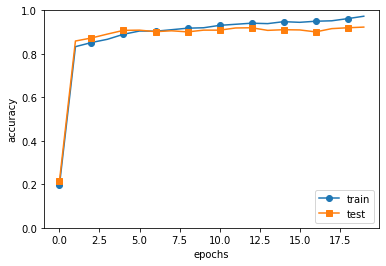

Computation time:5171.669 sec


In [13]:
# 処理に時間のかかる場合はデータを削減 
#x_train, t_train = x_train[:5000], t_train[:5000]
#x_test, t_test = x_test[:1000], t_test[:1000]


max_epochs = 20

#処理を始めた時間
start_time = time.time()


network = SimpleConvNet(input_dim=(1,28,28), 
                        conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)
                        
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()


# パラメータの保存
network.save_params("params.pkl")
print("Saved Network Parameters!")


# グラフの描画
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()
print('Computation time:{0:.3f} sec'.format(time.time() - start_time))

#  CNNの可視化
## 1層目の重みの可視化
- 4次元配列（データ数, チャネル数, 高さ, 幅)

MNISTデータセットでの1層目の重みは(30,1,5,5)

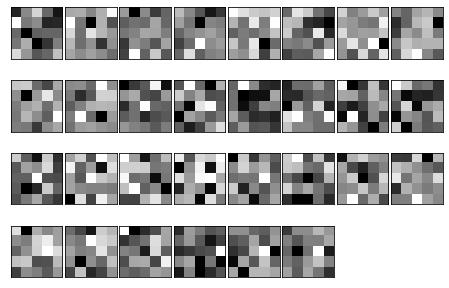

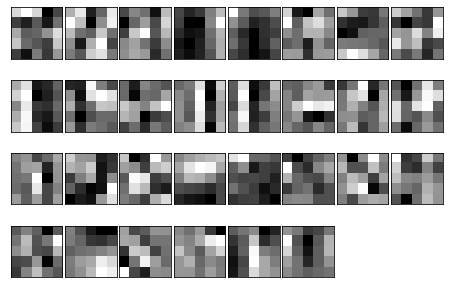

In [14]:
# coding: utf-8
import numpy as np
import matplotlib.pyplot as plt
# from simple_convnet import SimpleConvNet

def filter_show(filters, nx=8, margin=3, scale=10):
    """
    c.f. https://gist.github.com/aidiary/07d530d5e08011832b12#file-draw_weight-py
    """
    FN, C, FH, FW = filters.shape
    ny = int(np.ceil(FN / nx))

    fig = plt.figure()
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    for i in range(FN):
        ax = fig.add_subplot(ny, nx, i+1, xticks=[], yticks=[])
        ax.imshow(filters[i, 0], cmap=plt.cm.gray_r, interpolation='nearest')
    plt.show()


network = SimpleConvNet()
# ランダム初期化後の重み
filter_show(network.params['W1'])

# 学習後の重み
network.load_params("params.pkl")
filter_show(network.params['W1'])

In [24]:
#Get the predictions for the test data
p = network.predict(x_test)
predicted_classes = np.argmax(p , axis=1)

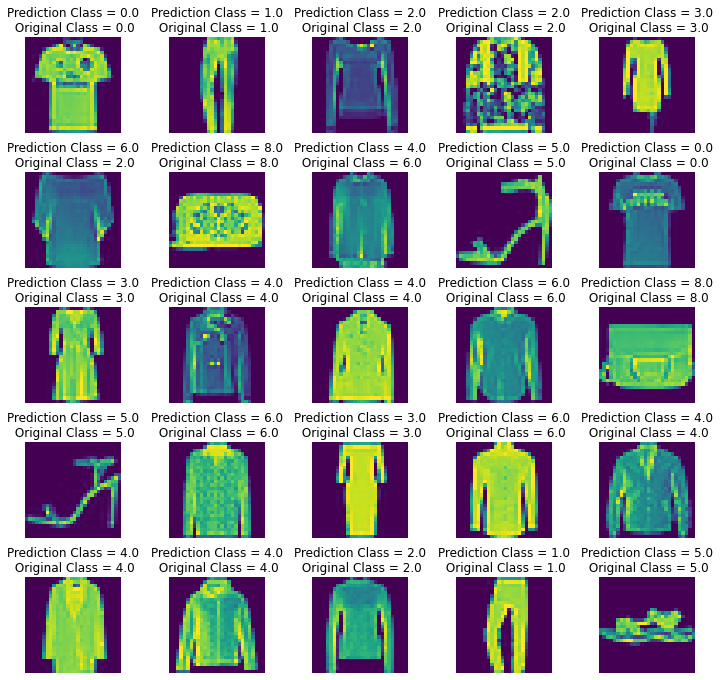

In [29]:
L = 5
W = 5
fig, axes = plt.subplots(L, W, figsize = (12,12))
axes = axes.ravel()

for i in np.arange(0, L * W):  
    axes[i].imshow(x_test[i].reshape(28,28))
    axes[i].set_title(f"Prediction Class = {predicted_classes[i]:0.1f}\n Original Class = {t_test[i]:0.1f}")
#    axes[i].set_title(f"Prediction Class = {predicted_classes[i]}\n Original Class = {t_test[i]}")
    axes[i].axis('off')

plt.subplots_adjust(wspace=0.5)